# Markowitz Optimization

## 1. Set a Goal

Is the objective to minimise risk or maximise Sharpe Ratio?

## 2. Select Asset Classes

Choose broad asset classes like:

Equities (Domestic and international stocks)
Fixed Income (Government bonds, corporate bonds)
Real Assets (REITs, commodities)
Cash and Cash Equivalents (Money market funds)


## 3. Apply Markovitz Optimization

__Monitor and Rebalance Periodically__

__Frequency__: Rebalance every 6-12 months. This strikes a good balance between maintaining the optimal allocation and minimizing trading costs.

__Thresholds__: Alternatively, rebalance only when an asset class deviates by more than a certain percentage (e.g., 5%) from its target weight.

Rebalancing Steps:

__Check__ your current allocation against the target weights.

__Sell__ assets that are overweight to reduce their allocation.

__Buy__ assets that are underweight to increase their allocation.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [11]:
# Define the ticker symbols
tickers = ['QQQ', 'SPY', 'TLT']  # QQQ for NASDAQ, SPY for S&P 500, TLT for 20-year US Bonds

# Fetch historical data
data = yf.download(tickers, start="1999-01-01", end="2014-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()


[*********************100%%**********************]  3 of 3 completed


In [12]:
# Calculate mean daily return and covariance of daily returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

num_assets = len(tickers)
# Initial weights set to equal distribution
weights = np.array([1/num_assets] * num_assets)

In [13]:
mean_returns

Ticker
QQQ    0.000575
SPY    0.000408
TLT    0.000281
dtype: float64

In [14]:
cov_matrix

Ticker,QQQ,SPY,TLT
Ticker,,,
QQQ,0.000206,0.000166,-0.000050
SPY,0.000166,0.000166,-0.000048
TLT,-0.000050,-0.000048,0.000078


In [30]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252  # Convert to annual returns
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annual standard deviation
    return std_dev, returns


# Objective function (minimize negative Sharpe ratio)
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_std, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

# Objective function (minimize variance)
def portfolio_variance(weights, mean_returns, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for each weight
bounds = tuple((0, 1) for asset in range(num_assets))
optimized_result = minimize(negative_sharpe, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimized weights
optimized_weights = optimized_result.x

print("Optimized Weights:\n")
for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.2%}")

Optimized Weights:

QQQ: 41.28%
SPY: 0.00%
TLT: 58.72%


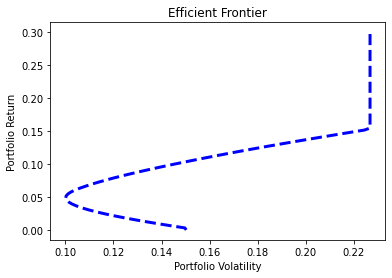

In [10]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

frontier_y = np.linspace(0, 0.3, 100)
frontier_x = []

for possible_return in frontier_y:
    cons = (constraints, {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - possible_return})
    result = minimize(portfolio_volatility, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

plt.plot(frontier_x, frontier_y, 'b--', linewidth=3)
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.show()


# Bootstrap

In [39]:
def bootstrap_resample(returns, n_bootstraps, n_days, log_steps=100):
    avg_weights = np.zeros(len(returns.columns))
    
    for i in range(n_bootstraps):
        # Resample the returns with replacement
        sample_indices = np.random.choice(range(len(returns)), size=n_days, replace=True)
        resampled_returns = returns.iloc[sample_indices]
        
        # Perform optimization on the resampled data
        weights = optimize_portfolio(resampled_returns)
        avg_weights += weights
        if i % log_steps == 0:
            print("Finished round:", i, weights*100)
    
    avg_weights /= n_bootstraps
    return avg_weights


def optimize_portfolio(rets):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    mean_returns = rets.mean()
    cov_matrix = rets.cov()

    bounds = tuple((0, 1) for asset in range(num_assets))
    optimized_result = minimize(negative_sharpe, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
#     optimized_result = minimize(portfolio_variance, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)


    optimized_weights = optimized_result.x
    return optimized_weights

In [41]:
weights = bootstrap_resample(returns, 500, 252)

print("Optimized Weights:\n")
for ticker, weight in zip(tickers, weights):
    print(f"{ticker}: {weight:.2%}")

Finished round: 0 [4.07583267e+01 1.21430643e-14 5.92416733e+01]
Finished round: 100 [ 0.         70.72231263 29.27768737]
Finished round: 200 [  0. 100.   0.]
Finished round: 300 [47.11085474  0.         52.88914526]
Finished round: 400 [ 0.         52.79188783 47.20811217]
Optimized Weights:

SPY: 32.86%
QQQ: 24.09%
TLT: 43.06%


# Validation

In [38]:
tickers = ['SPY', 'QQQ', 'TLT']
data = yf.download(tickers, start="2000-01-01", end="2023-12-31")['Adj Close']
returns = data.pct_change().dropna()

[*********************100%%**********************]  3 of 3 completed


In [47]:
def portfolio_annual_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_std, p_ret = portfolio_annual_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

def optimize_portfolio(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


def bootstrap_resample(returns, n_bootstraps, n_days, log_steps=100):
    avg_weights = np.zeros(len(returns.columns))
    
    for i in range(n_bootstraps):
        # Resample the returns with replacement
        sample_indices = np.random.choice(range(len(returns)), size=n_days, replace=True)
        resampled_returns = returns.iloc[sample_indices]
        
        # Perform optimization on the resampled data
        weights = optimize_portfolio(resampled_returns)
        avg_weights += weights
        if (i+1) % log_steps == 0:
            print("Finished round:", i+1, weights*100)
    
    avg_weights /= n_bootstraps
    return avg_weights

In [49]:
window = 10 
years = range(2010, 2024)
sharpe_markowitz = []
ret_markowitz = []
sharpe_equal = []
ret_equal = []

for year in years:
    print("Running year:", year)
    start_year = year - window
    end_year = year - 1
    returns_window = returns.loc[f"{start_year}-01-01":f"{end_year}-12-31"]

    # Optimize portfolio at the end of this window
    optimal_weights = bootstrap_resample(returns_window, 500, 252, log_steps=1000)
    next_year_returns = returns.loc[f"{year}-01-01":f"{year}-12-31"]
    
    # Calculate Sharpe ratio for Markowitz portfolio
    mean_returns = next_year_returns.mean()
    cov_matrix = next_year_returns.cov()
    std_dev, ret = portfolio_annual_performance(optimal_weights, mean_returns, cov_matrix)
    sharpe_markowitz.append((ret - 0.01) / std_dev)
    ret_markowitz.append(ret)

    # Calculate Sharpe ratio for equal weight portfolio
    equal_weights = np.array([1/3, 1/3, 1/3])
    std_dev, ret = portfolio_annual_performance(equal_weights, mean_returns, cov_matrix)
    sharpe_equal.append((ret - 0.01) / std_dev)
    ret_equal.append(ret)

# Output the results
results = pd.DataFrame({
    'Year': years,
    'Sharpe_Markowitz': sharpe_markowitz,
    'Sharpe_Equal': sharpe_equal,
    'Ret_Markowitz': ret_markowitz,
    'Ret_Equal': ret_equal,
})
print(results)


Running year: 2010
Running year: 2011
Running year: 2012
Running year: 2013
Running year: 2014
Running year: 2015
Running year: 2016
Running year: 2017
Running year: 2018
Running year: 2019
Running year: 2020
Running year: 2021
Running year: 2022
Running year: 2023
    Year  Sharpe_Markowitz  Sharpe_Equal  Ret_Markowitz  Ret_Equal
0   2010          1.569670      1.382158       0.139003   0.152554
1   2011          2.075249      1.090863       0.195775   0.140225
2   2012          1.229973      1.561568       0.091771   0.123750
3   2013          0.914824      1.866087       0.080838   0.157012
4   2014          3.053656      2.427300       0.201343   0.188284
5   2015          0.249073      0.304943       0.032879   0.041450
6   2016          0.604548      0.712041       0.058938   0.074497
7   2017          2.913192      3.286963       0.177687   0.193907
8   2018         -0.110453     -0.130082      -0.001877  -0.006528
9   2019          2.929685      2.865702       0.250056   0.2537

In [50]:
m, s = results['Sharpe_Markowitz'].mean(), results['Sharpe_Markowitz'].std()
print("Markowitz sharpe mean:", m, "std:", s)

m, s = results['Sharpe_Equal'].mean(), results['Sharpe_Equal'].std()
print("Equal sharpe mean:", m, "std:", s)

Markowitz sharpe mean: 1.3070832274517605 std: 1.2792074443203352
Equal sharpe mean: 1.324126420963171 std: 1.2262950316187808
